# Kevin's analysis Jupyter Notebook

This is going to be merged with Nik's once we have all the different analysis types we want put together

We start by pulling in the "environment classes" which has the ppo waterworld class inside

In [1]:
from util import environment_classes

let's start by training and examining an instance with a single agent, no cooperation


Finished loop 1 of 3
Finished loop 2 of 3
Finished loop 3 of 3


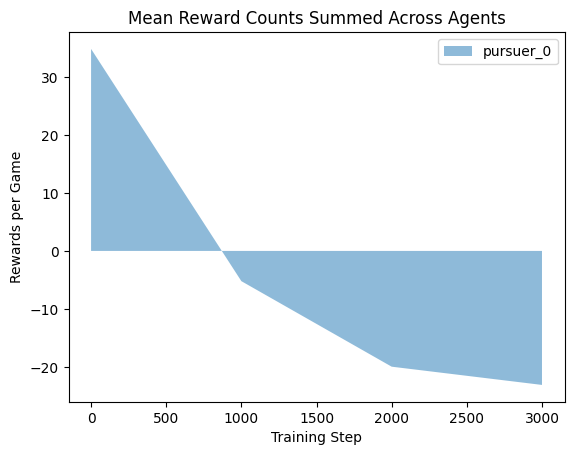

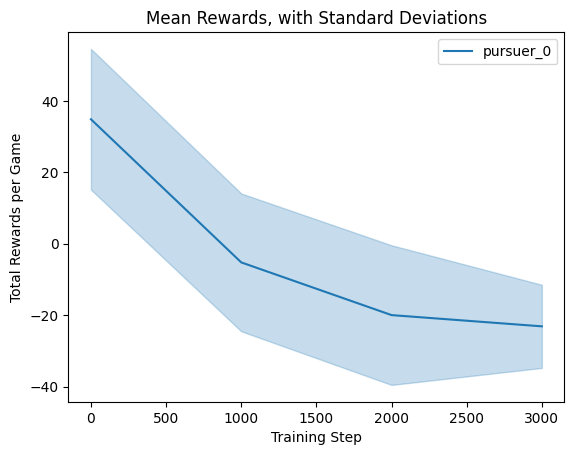

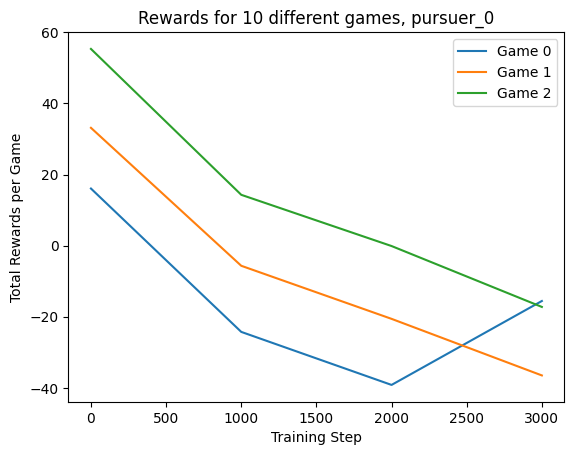

In [2]:
# call the waterworld_ppo class with custom options -- only one agent needs to touch, and only one pursuer
single_agent = environment_classes.waterworld_ppo(log_dir='log_dir/single_agent_preset_env', n_coop = 1, n_pursuers = 1)

# we're going to run a train/test loop. 20 iterations of each, 100,000 steps per training loop, 10 games per evaluation set
single_agent.interlace_run(num_loops=3, num_games=3, num_steps=1000)

# now let's plot the results
single_agent.plot_rewards()

now let's try a basic 4 agent, cooperation = 2 setup. This doesn't use CTDE, so there isn't any coordinated learning in any way

In [ ]:
basic_multi = environment_classes.waterworld_ppo(log_dir='log_dir/basic_multi_short', n_coop = 2, n_pursuers = 4)
basic_multi.interlace_run(num_loops=300, num_games=10, num_steps=10000)
basic_multi.plot_rewards()

In [6]:
import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy as PPOMlpPolicy
from pettingzoo.test import seed_test, parallel_seed_test, test_save_obs

from pettingzoo.sisl import waterworld_v4

In [7]:
env = waterworld_v4.parallel_env(render_mode='rgb_array') # initialize environment
eval_env = waterworld_v4.env()

In [8]:
env.reset()

({'pursuer_0': array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.

In [12]:
def render_env(instance, frame_rate:float = 30, num_frames:float = 500, name_suffix:str = None):
    '''
    render a video in the log_dir 
    
    Args:
        frame_rate  :   frame rate in hertz for rendered video [30]
        num_frames  :   number of frames to render [500]
        name_app    :   suffix for video name. If None, will append current timestamp
    '''
    env_kwargs = instance.env_kwargs
    env = waterworld_v4.env(**env_kwargs, max_cycles = num_frames, render_mode = 'rgb_array') # load environment
    # env = waterworld_v4.env(**env_kwargs, max_cycles = num_frames, render_mode = 'human') # load environment

    # reward and rendering stuff
    env.reset()
    rewards = {agent:0 for agent in env.agents}
    frame = np.ndarray((750,750,3,num_frames*len(env.agents)), dtype=int)
    model = instance.model

    # play through each turn
    ii_loop = 0
    for agent in env.agent_iter():
        # get the action for this iteration
        obs, reward, termination, truncation, info = env.last()

        # get the rewards per agent
        # have to do this separately since we're using AEC instead of parallel
        for agent_r in env.agents:
            rewards[agent_r] += env.rewards[agent_r]

        # has the game stopped?
        if termination or truncation:
            break
        else:
            act = model.predict(obs, deterministic=True)[0]

        env.step(act)
        # env.render()
        frame[:,:,:,ii_loop] = env.render()
        ii_loop +=1

    return frame

    # # write the frames to a video
    
    # # filename stuff
    # if name_suffix is None:
    #     name_suffix = time.strftime('%Y%m%d_%H%M%S')
    # filename = instance.env.unwrapped.metadata['name']+name_suffix+'.mp4'
    # filename = os.path.join(instance.log_dir,filename)
    # fps = frame_rate*len(env.agents) # to account for turns

    # # open the VideoWriter object, write all of the frames to it
    # vid_writer =  cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'XVID'), fps, (750,750))
    # for i_frame in range(num_frames*len(env.agents)):
    #     vid_writer.write(frame[:,:,:,i_frame])
    # vid_writer.release()
    

In [ ]:
numel(frame)

In [13]:
frame = render_env(single_agent)

In [ ]:
actions = {agent: env.action_space(agent).sample() for agent in env.agents}
env.step(actions)
frame = env.render()


In [9]:
import pandas as pd
import cv2
import numpy as np
import time
import os

In [ ]:
log_pd = pd.read_csv(single_agent.reward_csv_file)

In [ ]:
log_pd_mean = log_pd.groupby('Timestamp')[[key for key in log_pd.keys() if 'pursuer' in key]].mean()

max_ind = log_pd_mean.sum(axis=1).argmax()

timestamp = log_pd_mean.index[max_ind]

In [ ]:
f'{single_agent.train_stepcount:07d}'

In [ ]:
500/30
